In [1]:
from math import nan
from pathlib import Path

from gspread import service_account, Spreadsheet
from numpy import array
from pandas import DataFrame
from statsmodels.stats.inter_rater import fleiss_kappa

In [2]:
sheet_url = "https://docs.google.com/spreadsheets/d/1ud5ij645_khLMiydH3g_Dun9YCEeToWJnICw5a1RfNo/edit"
sheet_id = 0

In [ ]:
data_path = Path("../data")
figures_path = data_path / "figures"

In [3]:
query = 19

In [4]:
column_categories = {
    '2.1.A.': ["0", "1"],
    '2.1.B.': ["0", "1"],
    '2.2.A.': ["0", "1"],
    '2.2.B.': ["0", "1"],
    '2.3.': ["1", "2", "3", "4", "5", "6", "99"],
    '2.3.1.': ["1", "2", "3", "99"],
    '2.3.A.': ["0", "1"],
    '2.3.B.': ["0", "1"],
    '3.1.': ["1", "2", "3", "4", "99"],
    '3.2.': ["1", "2", "3", "4", "5", "99"],
    '3.3.': ["1", "2", "3", "4", "99"],
    '4.1.1.': ["0", "1"],
    '4.1.2.': ["0", "1"],
    '4.1.3.': ["0", "1"],
    '4.1.4.': ["0", "1"],
    '4.1.5.': ["0", "1"],
    '4.1.6.': ["0", "1"],
    '4.1.7.': ["0", "1"],
    '4.1.99.': ["0", "1"],
    '4.2.': ["1", "2", "3", "4", "99"],
    '5.1.': ["1", "2", "3", "4", "5", "6", "99"],
    '5.2.': ["1", "2", "3", "4", "99"],
    '5.3.': ["1", "2", "3", "4"],
    '5.4.': ["0", "1"],
    '6.1.': ["1", "2", "3", "99"],
    '6.2.': ["1", "2", "99"],
    '6.3.': ["1", "2", "99"],
    '7': ["1", "2", "3"],
    '7.1.': ["0", "1"],
}
columns = list(column_categories.keys())

In [5]:
sheets = service_account("google-services.json")

In [6]:
sheet: Spreadsheet = sheets.open_by_url(sheet_url)

In [7]:
values = sheet.get_worksheet_by_id(sheet_id).get_all_values()

In [8]:
def haltung_staerke(x: str) -> str:
    if x == "1" or x == "5":
        return "3"
    elif (x == "2" or 
          x == "4"):
        return "2"
    elif x == "3" or x == "6":
        return "1"
    elif x == "99":
        return "99"
    else:
        raise Exception(x)

In [9]:
data = DataFrame(values[2:], columns=values[0])

# Spalten löschen
# del data["1.3."]
# del data["1.4."]
# del data["1.5."]
# del data["Relevanzkriterium"]
# del data["Haltung"]
# del data["Nutzbarkeit"]
# del data["Inhalt"]
# del data["Glaubwürdigkeit"]
# del data["Aktualität"]
# del data["QUALITÄT"]

data["1.6."] = data["1.6."].str.strip()
data["1.7."] = data["1.7."].str.strip()

# Umcodierung
data["2.1.A."] = ((data["2.1."] == "1") | (data["2.1."] == "3")).astype(int).astype(str)
data["2.1.B."] = ((data["2.1."] == "2") | (data["2.1."] == "3")).astype(int).astype(str)
# del data["2.1."]

# Umcodierung
data["2.2.A."] = ((data["2.2."] == "1") | (data["2.2."] == "3")).astype(int).astype(str)
data["2.2.B."] = ((data["2.2."] == "2") | (data["2.2."] == "3")).astype(int).astype(str)
# del data["2.2."]

data.loc[data["5.2."] == "99", "2.3."] = "99"
data["2.3.1."] = data["2.3."].map(haltung_staerke).astype(int).astype(str)
data["2.3.A."] = ((data["2.3."] == "1") | (data["2.3."] == "2")).astype(int).astype(str)
data["2.3.B."] = ((data["2.3."] == "4") | (data["2.3."] == "5")).astype(int).astype(str)

# Daten aufbereiten
data["4.1."] = data["4.1."].str.replace(";", ",")
data["4.1."] = data["4.1."].str.replace(" ", "")
data["4.1."] = data["4.1."].str.removesuffix(",")
data["4.1."] = data["4.1."].map(lambda text: set(text.split(",")))
for element in ["1", "2", "3", "4", "5", "6", "7", "99"]:
    data[f"4.1.{element}."] = data["4.1."].map(lambda labels: str(int(element in labels)))
# del data["4.1."]

# Umcodierung
data["5.4."] = data["5.4."].str.replace(";", ",")
data["5.4."] = data["5.4."].str.replace(" ", "")
data["5.4."] = data["5.4."].str.removesuffix(",")
data["5.4."] = data["5.4."].map(lambda text: set(text.split(",")))
data["5.4."] = data["5.4."].map(
    lambda labels: "1" in labels or "2" in labels or "3" in labels or "99" in labels).astype(int).astype(str)

# Umcodierung
data["7.1."] = ((data["7"] == "2") | (data["7"] == "3")).astype(int).astype(str)

data.head()

,1.1.,Codierer,Hintergrund,1.2.,1.3.,1.4.,1.5.,1.6.,1.7.,2.1.,...,2.3.B.,4.1.1.,4.1.2.,4.1.3.,4.1.4.,4.1.5.,4.1.6.,4.1.7.,4.1.99.,7.1.
0,1,Paula,1,1,Was sind die Vor- und Nachteile von PHP gegenü...,Ohne frühere Programmiererfahrung plant ein ju...,https://web.archive.org/web/20220504110310/htt...,PHP,Python,3,...,1,1,1,1,1,1,0,0,0,1
1,1,Paula,1,2,Was sind die Vor- und Nachteile von PHP gegenü...,Ohne frühere Programmiererfahrung plant ein ju...,https://web.archive.org/web/20220504110445/htt...,PHP,Python,3,...,0,1,1,1,1,0,0,0,0,1
2,1,Paula,1,3,Was sind die Vor- und Nachteile von PHP gegenü...,Ohne frühere Programmiererfahrung plant ein ju...,https://web.archive.org/web/20220504110927/htt...,PHP,Python,3,...,0,1,1,0,1,0,0,0,0,1
3,1,Paula,1,4,Was sind die Vor- und Nachteile von PHP gegenü...,Ohne frühere Programmiererfahrung plant ein ju...,https://web.archive.org/web/20220505172700/htt...,PHP,Python,3,...,1,1,1,0,0,0,0,0,0,1
4,2,Luisa,1,5,Warum ist Linux besser als Windows?,"Ein Windows-Benutzer satt, unkontrollierte Upd...",https://www.software-eule.de/blogs/software-ma...,Linux,Windows,3,...,0,1,0,0,1,0,0,0,0,1


In [10]:
agreement_data = data.copy()
agreement_data = agreement_data[agreement_data["1.1."] == str(query)]
agreement_data["Subject"] = agreement_data["1.1."].str.cat(agreement_data["1.2."], sep="-")
agreement_data = agreement_data[["Subject", "Codierer", *columns]]
agreement_data.sort_values(by=["Subject", "7"], inplace=True)
agreement_data.head()

,Subject,Codierer,2.1.A.,2.1.B.,2.2.A.,2.2.B.,2.3.,2.3.1.,2.3.A.,2.3.B.,...,4.2.,5.1.,5.2.,5.3.,5.4.,6.1.,6.2.,6.3.,7,7.1.
72,19-73,Luisa,1,1,1,1,3,1,0,0,...,3,2,1,1,0,1,99,2,1,0
73,19-73,Johannes,1,1,1,1,3,1,0,0,...,4,5,4,1,0,99,99,1,1,0
74,19-73,Paula,1,1,0,0,3,1,0,0,...,2,2,1,1,0,3,2,2,1,0
75,19-73,Lena,1,1,1,1,3,1,0,0,...,4,99,4,1,0,2,2,1,1,0
76,19-73,Sonja,1,1,0,1,3,1,0,0,...,4,5,4,1,0,2,99,1,1,0


In [11]:
subjects = agreement_data["Subject"].unique()
subjects

array(['19-73', '19-74', '19-75', '19-76'], dtype=object)

In [12]:
def column_fleiss_kappa(column: str) -> float:
    categories = column_categories[column]
    table = array([
        [
            len(agreement_data[(agreement_data["Subject"] == subject) & (agreement_data[column] == category)])
            for category in categories
        ]
        for subject in subjects
    ])
    return fleiss_kappa(table)

In [13]:
agreement = DataFrame([
    {
        "Frage": column,
        "Fleiss' κ": column_fleiss_kappa(column),
    }
    for column in columns
])
agreement

/home/heinrich/.local/share/virtualenvs/master-s8JoE7B2/lib/python3.9/site-packages/statsmodels/stats/inter_rater.py:264: RuntimeWarning: invalid value encountered in double_scalars
  kappa = (p_mean - p_mean_exp) / (1- p_mean_exp)


,Frage,Fleiss' κ
0,2.1.A.,NaN
1,2.1.B.,NaN
2,2.2.A.,-0.101614
3,2.2.B.,-0.001001
4,2.3.,0.428735
5,2.3.1.,0.514074
6,2.3.A.,NaN
7,2.3.B.,NaN
8,3.1.,-0.011568
9,3.2.,0.243124


In [14]:
agreement.to_excel("agreement.xlsx")

In [15]:
data.to_excel("umcodiert.xlsx")

In [108]:
from pandas import Series
from collections import Counter

analytics_data = data.copy()


def majority_vote(items: Series):
    counter = Counter(items.tolist())
    _, most_common_count = counter.most_common(1)[0]
    most_common = {key for key in counter.keys() if counter[key] == most_common_count}
    most_common = list(sorted(most_common))
    return most_common[0] if len(most_common) >= 1 else nan


analytics_data = analytics_data.groupby(by=["1.1.", "1.2."]).aggregate(majority_vote).reset_index()
analytics_data

/tmp/ipykernel_310843/3482714391.py:15: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  analytics_data = analytics_data.groupby(by=["1.1.", "1.2."]).aggregate(majority_vote).reset_index()


,1.1.,1.2.,Codierer,Hintergrund,1.3.,1.4.,1.5.,1.6.,1.7.,2.1.,...,2.3.B.,4.1.1.,4.1.2.,4.1.3.,4.1.4.,4.1.5.,4.1.6.,4.1.7.,4.1.99.,7.1.
0,1,1,Paula,1,Was sind die Vor- und Nachteile von PHP gegenü...,Ohne frühere Programmiererfahrung plant ein ju...,https://web.archive.org/web/20220504110310/htt...,PHP,Python,3,...,1,1,1,1,1,1,0,0,0,1
1,1,2,Paula,1,Was sind die Vor- und Nachteile von PHP gegenü...,Ohne frühere Programmiererfahrung plant ein ju...,https://web.archive.org/web/20220504110445/htt...,PHP,Python,3,...,0,1,1,1,1,0,0,0,0,1
2,1,3,Paula,1,Was sind die Vor- und Nachteile von PHP gegenü...,Ohne frühere Programmiererfahrung plant ein ju...,https://web.archive.org/web/20220504110927/htt...,PHP,Python,3,...,0,1,1,0,1,0,0,0,0,1
3,1,4,Paula,1,Was sind die Vor- und Nachteile von PHP gegenü...,Ohne frühere Programmiererfahrung plant ein ju...,https://web.archive.org/web/20220505172700/htt...,PHP,Python,3,...,1,1,1,0,0,0,0,0,0,1
4,10,37,Sonja,1,Sollte ich Python oder R zur Datenanalyse lernen?,"Sie fragen sich, ob Sie Python oder R für die ...",https://web.archive.org/web/20220504132031/htt...,Python,R,3,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,8,32,10,1,"Welcher Algorithmus ist besser, Quicksort oder...","Dies ist eine häufige Frage, die in Data Scien...",https://web.archive.org/web/20220516100138/htt...,Quicksort,Mergesort,3,...,0,1,0,0,1,0,0,0,0,1
116,9,33,Jürgen,1,Sind Random-Forest-Klassikator besser als deci...,Maschinelles Lernen ist ein umfangreiches Fors...,https://web.archive.org/web/20220504131404/htt...,Ramdom-Forest-Klassikator,decision trees,3,...,0,1,0,0,0,0,0,0,0,1
117,9,34,Jürgen,1,Sind Random-Forest-Klassikator besser als deci...,Maschinelles Lernen ist ein umfangreiches Fors...,https://web.archive.org/web/20220504131536/htt...,Ramdom-Forest-Klassikator,decision trees,3,...,0,1,0,1,0,0,0,0,0,1
118,9,35,Jürgen,1,Sind Random-Forest-Klassikator besser als deci...,Maschinelles Lernen ist ein umfangreiches Fors...,https://web.archive.org/web/20220504131702/htt...,Ramdom-Forest-Klassikator,decision trees,3,...,0,1,0,0,0,0,0,0,0,1


In [17]:
analytics_data.to_excel("umcodiert_majority_vote.xlsx")

In [18]:
def score_umfang(value: str) -> float:
    if value == "1":
        return 1
    elif value == "2":
        return 2
    elif value == "3":
        return 3
    elif value == "4":
        return 4
    elif value == "5":
        return 0
    else:
        return nan

In [19]:
def score_sprache(value: str) -> float:
    if value == "1":
        return 2
    elif value == "2":
        return 1
    elif value == "3":
        return 0
    elif value == "4":
        return 0
    else:
        return nan

In [124]:
def score_lesbarkeit(value: str) -> float:
    if value == "1":
        return 0
    elif value == "2":
        return 1
    elif value == "3":
        return 2
    elif value == "4":
        return 3
    else:
        return nan

In [21]:
def score_quelle(value: str) -> float:
    if value == "1":
        return 2
    elif value == "2":
        return 2
    elif value == "3":
        return 0
    elif value == "4":
        return 1
    elif value == "5":
        return 1
    elif value == "6":
        return 0
    else:
        return nan

In [22]:
def score_autor(value: str) -> float:
    if value == "1":
        return 2
    elif value == "2":
        return 1
    elif value == "3":
        return 0
    elif value == "4":
        return 1
    elif value == "99":
        return 1
    else:
        return nan

In [23]:
def score_wahrheit(value: str) -> float:
    if value == "1":
        return 1
    elif value == "2":
        return 0
    elif value == "3":
        return 0.5
    elif value == "4":
        return 1
    else:
        return nan

In [24]:
def score_datum(value: str) -> float:
    if value == "1":
        return 1
    elif value == "2":
        return 2
    elif value == "3":
        return 2
    elif value == "99":
        return 0
    else:
        return nan

In [25]:
def score_updates(value: str) -> float:
    if value == "1":
        return 1
    elif value == "2":
        return 0
    elif value == "99":
        return 0
    else:
        return nan

In [125]:
index_data = analytics_data.copy()
index_data["I-Haltung"] = (index_data["2.3.1."].astype(int).replace(99, nan) - 1) / 2
index_data["3.2.score"] = index_data["3.2."].map(score_umfang)
index_data["3.3.score"] = index_data["3.3."].map(score_sprache)
index_data["I-Inhalt"] = (index_data["3.3.score"] + index_data["3.2.score"]) / 6
index_data["4.2.score"] = index_data["4.2."].map(score_lesbarkeit)
index_data["I-Nutzerfreundlichkeit"] = (
                                               # index_data["4.1.3."].astype(int)
                                               # + index_data["4.1.4."].astype(int)
                                               # + index_data["4.1.6."].astype(int)
                                               # +
                                               index_data["4.2.score"]
                                       ) / 3#9
index_data["5.1.score"] = index_data["5.1."].map(score_quelle)
index_data["5.2.score"] = index_data["5.2."].map(score_autor)
index_data["5.3.score"] = index_data["5.3."].map(score_wahrheit)
index_data["I-Glaubwürdigkeit"] = ((
                                           (index_data["5.1.score"] * 2) +
                                           index_data["5.2.score"]
                                   ) * index_data["5.3.score"]) / 6
index_data["6.1.score"] = index_data["6.1."].map(score_datum)
index_data["6.2.score"] = index_data["6.2."].map(score_updates)
index_data["I-Aktualität"] = ((index_data["6.1.score"] * 2) + index_data["6.2.score"]) / 5
index_data["I-Qualität"] = (
                                   (index_data["I-Inhalt"] * 4) +
                                   (index_data["I-Nutzerfreundlichkeit"] * 4) +
                                   (index_data["I-Glaubwürdigkeit"] * 2) +
                                   index_data["I-Aktualität"]
                           ) / 11
index_data

,1.1.,1.2.,Codierer,Hintergrund,1.3.,1.4.,1.5.,1.6.,1.7.,2.1.,...,4.2.score,I-Nutzerfreundlichkeit,5.1.score,5.2.score,5.3.score,I-Glaubwürdigkeit,6.1.score,6.2.score,I-Aktualität,I-Qualität
0,1,1,Paula,1,Was sind die Vor- und Nachteile von PHP gegenü...,Ohne frühere Programmiererfahrung plant ein ju...,https://web.archive.org/web/20220504110310/htt...,PHP,Python,3,...,2,0.666667,1.0,1.0,1.0,0.500000,2,0,0.8,0.709091
1,1,2,Paula,1,Was sind die Vor- und Nachteile von PHP gegenü...,Ohne frühere Programmiererfahrung plant ein ju...,https://web.archive.org/web/20220504110445/htt...,PHP,Python,3,...,3,1.000000,1.0,1.0,1.0,0.500000,2,0,0.8,0.830303
2,1,3,Paula,1,Was sind die Vor- und Nachteile von PHP gegenü...,Ohne frühere Programmiererfahrung plant ein ju...,https://web.archive.org/web/20220504110927/htt...,PHP,Python,3,...,2,0.666667,1.0,1.0,1.0,0.500000,2,0,0.8,0.648485
3,1,4,Paula,1,Was sind die Vor- und Nachteile von PHP gegenü...,Ohne frühere Programmiererfahrung plant ein ju...,https://web.archive.org/web/20220505172700/htt...,PHP,Python,3,...,1,0.333333,2.0,1.0,1.0,0.833333,1,0,0.4,0.490909
4,10,37,Sonja,1,Sollte ich Python oder R zur Datenanalyse lernen?,"Sie fragen sich, ob Sie Python oder R für die ...",https://web.archive.org/web/20220504132031/htt...,Python,R,3,...,1,0.333333,1.0,2.0,1.0,0.666667,1,0,0.4,0.581818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,8,32,10,1,"Welcher Algorithmus ist besser, Quicksort oder...","Dies ist eine häufige Frage, die in Data Scien...",https://web.archive.org/web/20220516100138/htt...,Quicksort,Mergesort,3,...,3,1.000000,2.0,2.0,1.0,1.000000,1,0,0.4,0.763636
116,9,33,Jürgen,1,Sind Random-Forest-Klassikator besser als deci...,Maschinelles Lernen ist ein umfangreiches Fors...,https://web.archive.org/web/20220504131404/htt...,Ramdom-Forest-Klassikator,decision trees,3,...,2,0.666667,1.0,2.0,1.0,0.666667,1,0,0.4,0.703030
117,9,34,Jürgen,1,Sind Random-Forest-Klassikator besser als deci...,Maschinelles Lernen ist ein umfangreiches Fors...,https://web.archive.org/web/20220504131536/htt...,Ramdom-Forest-Klassikator,decision trees,3,...,0,0.000000,0.0,2.0,1.0,0.333333,2,0,0.8,0.496970
118,9,35,Jürgen,1,Sind Random-Forest-Klassikator besser als deci...,Maschinelles Lernen ist ein umfangreiches Fors...,https://web.archive.org/web/20220504131702/htt...,Ramdom-Forest-Klassikator,decision trees,3,...,2,0.666667,1.0,1.0,1.0,0.500000,1,1,0.6,0.630303


In [126]:
index_data.to_excel("scores.xlsx")

In [127]:
from math import ceil
from matplotlib import pyplot as plt


def hist(col: str, bins: int):
    n, bins, patches = plt.hist(x=index_data[col], bins=bins, color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Wert')
    plt.ylabel('Häufigkeit')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.xlim(xmin=0, xmax=1)
    plt.ylim(ymax=ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.savefig(figures_path / f"Histogramm_{col}.png")
    plt.savefig(figures_path / f"Histogramm_{col}.pdf")

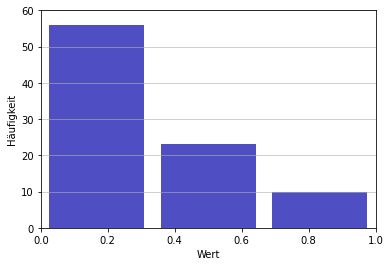

In [128]:
hist("I-Haltung", 3)

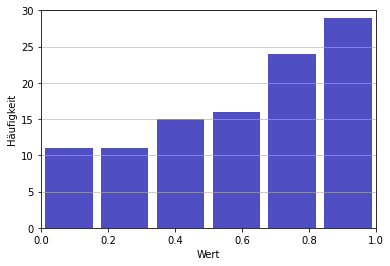

In [132]:
hist("I-Inhalt", 6)

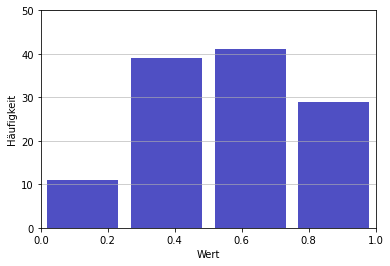

In [133]:
hist("I-Nutzerfreundlichkeit", 4)

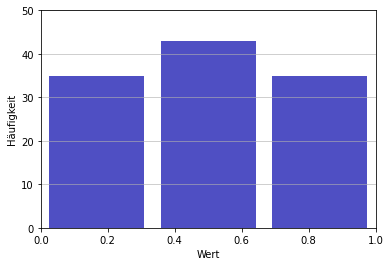

In [134]:
hist("I-Glaubwürdigkeit", 3)

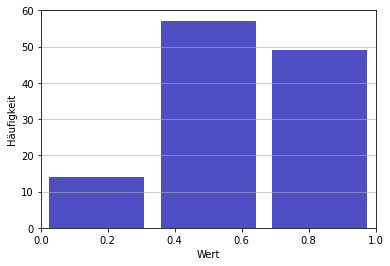

In [135]:
hist("I-Aktualität", 3)

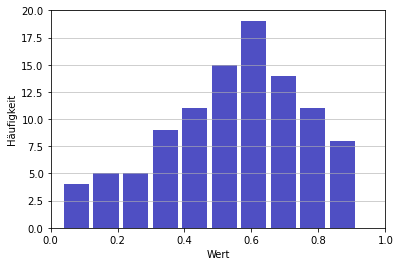

In [136]:
hist("I-Qualität", 10)

In [137]:
index_data["7.1."] = index_data["7.1."].astype(int)

In [138]:
from seaborn import heatmap

corr_data = DataFrame()
corr_data[[
    "Haltung",
    "Inhalt",
    "Nutzerfreundlichkeit",
    "Glaubwürdigkeit",
    "Aktualität",
    "Qualität",
    "Relevanz"
]] = index_data[[
    "I-Haltung",
    "I-Inhalt",
    "I-Nutzerfreundlichkeit",
    "I-Glaubwürdigkeit",
    "I-Aktualität",
    "I-Qualität",
    "7.1."
]]
corr_data = corr_data.fillna(0)
corr = corr_data.corr()
corr

,Haltung,Inhalt,Nutzerfreundlichkeit,Glaubwürdigkeit,Aktualität,Qualität,Relevanz
Haltung,1.000000,0.107353,0.020901,0.026214,-0.097015,0.091198,0.266249
Inhalt,0.107353,1.000000,0.330653,0.204643,-0.016682,0.733503,0.525284
Nutzerfreundlichkeit,0.020901,0.330653,1.000000,0.399852,0.012586,0.551732,0.087952
Glaubwürdigkeit,0.026214,0.204643,0.399852,1.000000,0.078235,0.622604,0.008311
Aktualität,-0.097015,-0.016682,0.012586,0.078235,1.000000,0.080983,-0.001996
Qualität,0.091198,0.733503,0.551732,0.622604,0.080983,1.000000,0.319391
Relevanz,0.266249,0.525284,0.087952,0.008311,-0.001996,0.319391,1.000000


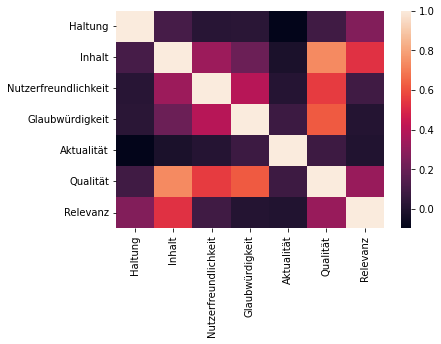

In [139]:
heatmap(corr)
plt.savefig(figures_path / "Qualität_Korrelation.png")
plt.savefig(figures_path / "Qualität_Korrelation.pdf")

In [140]:
index_data.groupby("Hintergrund").aggregate("mean")

,7.1.,I-Haltung,3.2.score,3.3.score,I-Inhalt,4.2.score,I-Nutzerfreundlichkeit,5.1.score,5.2.score,5.3.score,I-Glaubwürdigkeit,6.1.score,6.2.score,I-Aktualität,I-Qualität
Hintergrund,,,,,,,,,,,,,,,
1,0.650,0.203704,1.941176,1.514286,0.580808,1.475,0.491667,0.692308,1.175000,0.9500,0.418803,1.225,0.225,0.535,0.515530
2,0.350,0.250000,1.473684,1.200000,0.439394,1.775,0.591667,1.277778,1.050000,0.9250,0.557870,1.475,0.175,0.625,0.545943
3,0.675,0.264706,1.950000,1.450000,0.566667,1.950,0.650000,1.051282,1.025641,0.8875,0.480263,1.175,0.275,0.525,0.574242


In [141]:
index_data.groupby("1.1.").aggregate("mean")  #[["I-Haltung", "I-Qualität"]]

,7.1.,I-Haltung,3.2.score,3.3.score,I-Inhalt,4.2.score,I-Nutzerfreundlichkeit,5.1.score,5.2.score,5.3.score,I-Glaubwürdigkeit,6.1.score,6.2.score,I-Aktualität,I-Qualität
1.1.,,,,,,,,,,,,,,,
1,1.00,0.250000,2.50,1.750000,0.708333,2.00,0.666667,1.250000,1.00,1.000,0.583333,1.75,0.00,0.70,0.669697
10,0.75,0.125000,2.75,1.750000,0.750000,1.00,0.333333,0.250000,1.75,0.875,0.354167,1.25,0.00,0.50,0.503788
11,0.25,0.250000,0.75,1.000000,0.291667,1.50,0.500000,1.750000,1.00,1.000,0.750000,1.00,0.25,0.45,0.465152
12,0.25,0.000000,1.25,2.000000,0.555556,2.00,0.666667,1.250000,1.00,1.000,0.583333,1.25,0.00,0.50,0.664646
13,0.50,0.500000,1.25,0.666667,0.333333,1.50,0.500000,1.000000,1.00,1.000,0.500000,2.00,0.25,0.85,0.507071
14,0.50,0.375000,2.50,1.666667,0.666667,1.75,0.583333,1.333333,1.25,0.875,0.666667,1.25,0.25,0.55,0.688889
15,0.75,0.250000,1.75,1.250000,0.500000,2.25,0.750000,1.750000,1.00,0.500,0.375000,2.00,0.25,0.85,0.600000
16,0.00,0.250000,1.00,1.500000,0.416667,3.00,1.000000,1.333333,1.25,1.000,0.666667,1.75,0.00,0.70,0.824242
17,0.25,0.250000,2.25,1.250000,0.583333,2.25,0.750000,2.000000,1.00,1.000,0.833333,1.75,0.00,0.70,0.700000


In [142]:
index_data.groupby("Codierer").aggregate("mean")

,7.1.,I-Haltung,3.2.score,3.3.score,I-Inhalt,4.2.score,I-Nutzerfreundlichkeit,5.1.score,5.2.score,5.3.score,I-Glaubwürdigkeit,6.1.score,6.2.score,I-Aktualität,I-Qualität
Codierer,,,,,,,,,,,,,,,
10,0.687500,0.000000,1.437500,1.285714,0.452381,1.375000,0.458333,0.500000,1.125000,0.843750,0.327381,1.062500,0.437500,0.512500,0.440326
Andi,0.666667,0.250000,1.500000,1.400000,0.500000,1.500000,0.500000,0.833333,1.000000,0.916667,0.430556,1.666667,0.666667,0.800000,0.532727
Andi,0.833333,0.250000,1.000000,1.200000,0.400000,1.166667,0.388889,1.500000,1.000000,1.000000,0.666667,1.500000,0.500000,0.700000,0.495758
Angelique,0.416667,0.375000,2.375000,1.125000,0.583333,2.083333,0.694444,1.181818,1.000000,1.000000,0.560606,1.083333,0.000000,0.433333,0.726407
Johannes,0.625000,0.312500,2.375000,1.571429,0.642857,2.000000,0.666667,1.142857,1.250000,0.875000,0.583333,0.875000,0.250000,0.400000,0.648052
Jürgen,0.583333,0.500000,2.000000,1.500000,0.583333,1.083333,0.361111,0.750000,1.250000,0.916667,0.444444,1.000000,0.083333,0.416667,0.462121
Lena,0.666667,0.250000,2.000000,1.333333,0.555556,1.916667,0.638889,1.454545,0.916667,0.666667,0.393939,1.666667,0.250000,0.716667,0.561983
Luisa,0.666667,0.285714,1.583333,1.454545,0.515152,1.750000,0.583333,1.166667,1.000000,1.000000,0.555556,1.416667,0.166667,0.600000,0.571350
Patrick,0.083333,0.166667,1.500000,1.666667,0.520833,2.833333,0.944444,0.909091,1.083333,1.000000,0.484848,1.250000,0.083333,0.516667,0.662338


<AxesSubplot:>

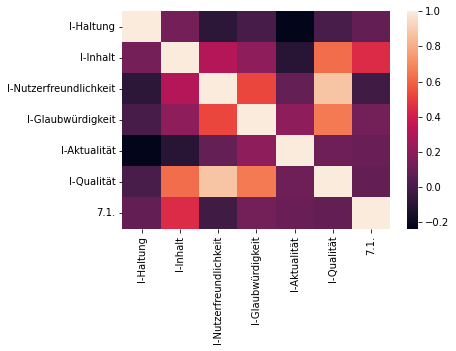

In [143]:
heatmap(index_data.groupby("1.1.").aggregate("mean")[[
    "I-Haltung",
    "I-Inhalt",
    "I-Nutzerfreundlichkeit",
    "I-Glaubwürdigkeit",
    "I-Aktualität",
    "I-Qualität",
    "7.1."
]].corr())